In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
# from keras.models import Sequential
import matplotlib.pyplot as plt

%matplotlib inline
from torchbearer import Trial
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.datasets import MNIST
from torchbearer import Trial
import torchvision.transforms as transforms

In [90]:
datapath = os.path.join(os.getcwd(), 'data')
datapath

'D:\\projects\\Stock-Market-Price-Prediction-master\\data'

In [91]:
df = pd.read_csv(os.path.join(datapath,'Integrated Data.csv'))
df.tail()

,Date,Adj Close,Volume,2-days Net change,5day-moving average,5day- standard deviation,10-day moving average,10day- standard deviation,50-day moving average,50day- standard deviation,^VIX,^TNX
3016,2016/12/23,2263.790039,2020550000,2.830078,2264.643994,3.757096,2262.528003,5.773423,2185.648188,54.155056,11.44,2.543
3017,2016/12/27,2268.879883,1987080000,5.089844,2265.913965,3.932965,2263.719995,5.726416,2188.366187,54.863455,11.99,2.563
3018,2016/12/28,2249.919922,2392360000,-18.959961,2261.745947,7.199588,2261.539990,6.446745,2190.834585,54.799583,12.95,2.506
3019,2016/12/29,2249.260010,2336370000,-0.659912,2258.561963,8.671128,2261.137988,7.110240,2193.027783,54.901540,13.37,2.477
3020,2016/12/30,2238.830078,2670900000,-10.429932,2254.135986,12.107894,2258.817993,9.989011,2194.918584,54.816670,14.04,2.446


# build binary classifier

In [92]:
# -1 --> tomorrow goes down 
# 0 --> tomorrow goes up
# initialising
df['forecasting'] = 0

df['forecasting_10daysout'] = float('nan')
df['forecasting_20daysout'] = float('nan')
df['forecasting_30daysout'] = float('nan')
# if y > sp500: predict as go up
# else predict as go down
for i in df.index:
    try:
        if df['Adj Close'][i+1] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting'] = 1
        else:
            df.at[i, 'forecasting'] = 0
    except:
        print('rearch the end')
        
for i in df.index:
    try:
        if df['Adj Close'][i+10] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_10daysout'] = 1
        else:
            df.at[i, 'forecasting_10daysout'] = 0
    except:
        print('rearch the end')
for i in df.index:
    try:
        if df['Adj Close'][i+20] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_20daysout'] = 1
        else:
            df.at[i, 'forecasting_20daysout'] = 0
    except:
        print('rearch the end')
for i in df.index:
    try:
        if df['Adj Close'][i+30] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_30daysout'] = 1
        else:
            df.at[i, 'forecasting_30daysout'] = 0
    except:
        print('rearch the end')

        
df = df.dropna(axis=0)

rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end


In [93]:
df

,Date,Adj Close,Volume,2-days Net change,5day-moving average,5day- standard deviation,10-day moving average,10day- standard deviation,50-day moving average,50day- standard deviation,^VIX,^TNX,forecasting,forecasting_10daysout,forecasting_20daysout,forecasting_30daysout
49,2005/3/15,1197.750000,1513530000,-9.079956,1204.183984,4.972205,1210.832996,9.015592,1194.796199,14.632914,13.150000,4.542,0,0.0,0.0,0.0
50,2005/3/16,1188.069946,1653190000,-9.680054,1200.395972,8.348981,1208.631995,11.550245,1194.515999,14.624728,13.490000,4.518,1,0.0,0.0,0.0
51,2005/3/17,1190.209961,1581930000,2.140015,1196.587964,7.610491,1206.605994,12.891081,1194.559197,14.608420,13.290000,4.470,0,0.0,0.0,0.0
52,2005/3/18,1189.650024,2344370000,-0.559937,1194.501977,7.840003,1203.358997,12.635974,1194.677397,14.542855,13.140000,4.511,0,0.0,0.0,0.0
53,2005/3/21,1183.780029,1819440000,-5.869995,1189.891992,5.064185,1199.205994,11.382360,1194.595198,14.593529,13.610000,4.525,0,0.0,0.0,0.0
54,2005/3/22,1171.709961,2114470000,-12.070068,1184.683984,7.677974,1194.433984,11.950460,1194.305598,14.904099,14.270000,4.610,1,1.0,0.0,1.0
55,2005/3/23,1172.530029,2246870000,0.820068,1181.576001,8.996683,1190.985986,12.858466,1193.951199,15.210042,14.060000,4.607,0,1.0,0.0,1.0
56,2005/3/24,1171.420044,1721720000,-1.109985,1177.818017,8.392663,1187.202991,12.446341,1193.719800,15.466059,13.420000,4.591,1,1.0,0.0,0.0
57,2005/3/28,1174.280029,1746220000,2.859985,1174.744018,5.172544,1184.622998,12.151021,1193.451401,15.687519,13.750000,4.624,0,1.0,0.0,1.0
58,2005/3/29,1165.359985,2223250000,-8.920044,1171.060010,3.375345,1180.476001,10.722586,1193.209602,16.028656,14.490000,4.591,1,1.0,0.0,1.0


Now instead of set the next day's value as target,
we will set the forecasting as target

In [94]:
print(len(df))
X = df.values[:,1:-4]
y = df.values[:,-1] # 30_days ahead forecasting
print(X.shape, y.shape)

2938
(2938, 11) (2938,)


In [95]:
X

array([[1197.75, 1513530000, -9.079956, ..., 14.63291434, 13.15, 4.542],
       [1188.069946, 1653190000, -9.680054, ..., 14.62472792, 13.49,
        4.518],
       [1190.209961, 1581930000, 2.140015, ..., 14.60842001, 13.29, 4.47],
       ...,
       [2164.199951, 5367200000, -0.25, ..., 22.14454909, 14.48, 2.222],
       [2180.389893, 4543860000, 16.189942000000002, ..., 21.93060761,
        13.37, 2.238],
       [2176.939941, 3830590000, -3.4499519999999997, ..., 21.61776338,
        13.72, 2.2230000000000003]], dtype=object)

# testing train_test_split.py

In [96]:
from train_test_split import utility_fun

In [97]:
temp = utility_fun([X, y], len_of_trainset = 2000, time_interval = 20, batch_size=32)

temp.norm()
temp.sepera_time_step()
temp.test_train_split()
trainloader, validateData, trainData, testData = temp.build_dataloader()
print(validateData.shape, trainData.shape, testData.shape)

torch.Size([919, 1, 20, 11]) torch.Size([2000, 1, 20, 11]) torch.Size([2000, 1])


In [98]:
trainData.shape
a = trainData.view(2000, -1, 11)

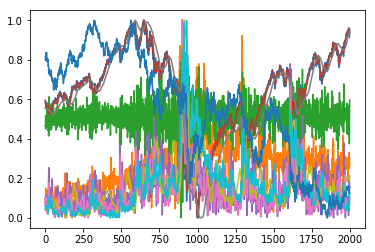

In [99]:
b = a[:,0,:]

for i in range(11):
    plt.plot(b[:,i].numpy())

# create model and training

In [100]:
# define baseline MLP model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)        
        out = self.fc2(out)
        out = F.sigmoid(out)
        out = out.squeeze()
        return out

In [101]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = BaselineModel(20*11, 220, 1)

# define the loss function and the optimiser
# loss_function = nn.MSELoss()

#classification problem  we use bce loss
loss_function = nn.BCELoss()
optimiser = optim.Adam(model.parameters())

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader)
trial.run(epochs=10)

[{'running_loss': 0.6675811409950256,
  'running_binary_acc': 0.621874988079071,
  'loss': 0.6710168719291687,
  'binary_acc': 0.6205000281333923,
  'train_steps': 63,
  'validation_steps': None},
 {'running_loss': 0.6558430194854736,
  'running_binary_acc': 0.6324999928474426,
  'loss': 0.6561803817749023,
  'binary_acc': 0.6340000033378601,
  'train_steps': 63,
  'validation_steps': None},
 {'running_loss': 0.6420575380325317,
  'running_binary_acc': 0.6506249904632568,
  'loss': 0.6428468823432922,
  'binary_acc': 0.6440000534057617,
  'train_steps': 63,
  'validation_steps': None},
 {'running_loss': 0.6356217265129089,
  'running_binary_acc': 0.6524999737739563,
  'loss': 0.6333234310150146,
  'binary_acc': 0.6530000567436218,
  'train_steps': 63,
  'validation_steps': None},
 {'running_loss': 0.6152740716934204,
  'running_binary_acc': 0.659375011920929,
  'loss': 0.6149956583976746,
  'binary_acc': 0.6570000052452087,
  'train_steps': 63,
  'validation_steps': None},
 {'running_l

In [102]:
torch.save(model.state_dict(), "mlp_model")

# generate gradient

In [103]:
class gradient_generator():
    
    def __init__(self, model):
        
        self.loss = nn.BCELoss()
        self.model = model.to('cpu')
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook = self.hook_layers()
    def hook_layers(self):    
        def hook_function(module, grad_in, grad_out):
#             print("hook called")
            self.gradients = grad_out[0]
#         print(list(self.model._modules.items()))
        first_layer = list(self.model._modules.items())[0][1]
        hook = first_layer.register_backward_hook(hook_function)
        return hook
    def generate_gradient(self, inputs, labels):
        self.model.zero_grad()
        output = self.model(inputs)
        loss = self.loss(output, labels)
        output.backward()
        
        self.hook.remove()
        return self.gradients
    

grad = torch.zeros((2000,220))
i = 0

for data in range(len(trainData)):
    inputs = trainData[data,:,:,:].view(1,-1)
    labs = testData[data,:].view(-1).float()
#     print(inputs.shape, labels.shape)
    GG = gradient_generator(model)
    temp = GG.generate_gradient(ins, labs)
    grad[i,:] = temp
    i += 1

In [104]:
grad.shape

torch.Size([2000, 220])

In [105]:
grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Visualisation

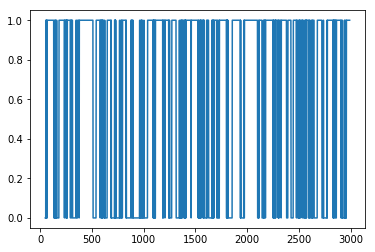

In [106]:
plt.plot(df['forecasting_30daysout'])

In [107]:
df.head()

,Date,Adj Close,Volume,2-days Net change,5day-moving average,5day- standard deviation,10-day moving average,10day- standard deviation,50-day moving average,50day- standard deviation,^VIX,^TNX,forecasting,forecasting_10daysout,forecasting_20daysout,forecasting_30daysout
49,2005/3/15,1197.750000,1513530000,-9.079956,1204.183984,4.972205,1210.832996,9.015592,1194.796199,14.632914,13.15,4.542,0,0.0,0.0,0.0
50,2005/3/16,1188.069946,1653190000,-9.680054,1200.395972,8.348981,1208.631995,11.550245,1194.515999,14.624728,13.49,4.518,1,0.0,0.0,0.0
51,2005/3/17,1190.209961,1581930000,2.140015,1196.587964,7.610491,1206.605994,12.891081,1194.559197,14.608420,13.29,4.470,0,0.0,0.0,0.0
52,2005/3/18,1189.650024,2344370000,-0.559937,1194.501977,7.840003,1203.358997,12.635974,1194.677397,14.542855,13.14,4.511,0,0.0,0.0,0.0
53,2005/3/21,1183.780029,1819440000,-5.869995,1189.891992,5.064185,1199.205994,11.382360,1194.595198,14.593529,13.61,4.525,0,0.0,0.0,0.0


In [108]:
# from sklearn import preprocessing

# df_norm = df.drop(columns=['Date','forecasting','forecasting_10daysout','forecasting_20daysout','forecasting_30daysout'],axis=0)
# x = df_norm.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_norm = pd.DataFrame(x_scaled)


In [109]:
# df_norm[0:20]

,0,1,2,3,4,5,6,7,8,9,10
0,0.344353,0.073485,0.463409,0.343898,0.047051,0.340791,0.062117,0.294076,0.037715,0.045935,0.818135
1,0.337958,0.086499,0.460565,0.341363,0.084703,0.339300,0.089056,0.293873,0.037656,0.050726,0.811953
2,0.339372,0.079859,0.516589,0.338815,0.076469,0.337927,0.103306,0.293904,0.037537,0.047908,0.799588
3,0.339002,0.150907,0.503792,0.337418,0.079028,0.335727,0.100595,0.293990,0.037059,0.045794,0.810149
4,0.335124,0.101991,0.478624,0.334333,0.048077,0.332912,0.087271,0.293930,0.037428,0.052417,0.813756
5,0.327149,0.129484,0.449236,0.330848,0.077221,0.329679,0.093309,0.293720,0.039692,0.061716,0.835652
6,0.327691,0.141822,0.510333,0.328768,0.091926,0.327342,0.102959,0.293464,0.041921,0.058757,0.834879
7,0.326958,0.092885,0.501185,0.326253,0.085191,0.324779,0.098579,0.293296,0.043787,0.049739,0.830757
8,0.328847,0.095168,0.520002,0.324195,0.049285,0.323030,0.095441,0.293101,0.045401,0.054389,0.839258
9,0.322954,0.139621,0.464167,0.321730,0.029245,0.320220,0.080259,0.292926,0.047887,0.064816,0.830757


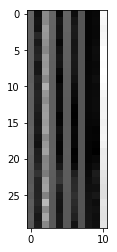

In [110]:
plt.imshow(df_norm[0:30], cmap=plt.get_cmap('gray'))

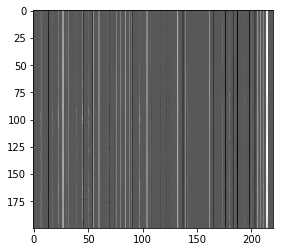

In [114]:
a = trainData.view(len(trainData),-1).float()
image = a[500:700, :]
grad_img = grad.data[500:700,:]

plt.imshow(grad_img * image, cmap=plt.get_cmap('gray'))

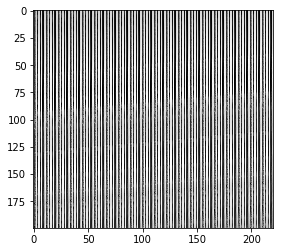

In [115]:
plt.imshow(image, cmap=plt.get_cmap('gray'))

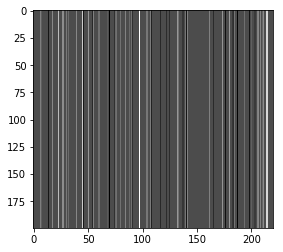

In [116]:
plt.imshow(grad_img, cmap=plt.get_cmap('gray'))

# sliding windows

In [111]:
from train_test_split import utility_fun

#classification problem  we use bce loss
loss_function = nn.BCELoss()
optimiser = optim.Adam(model.parameters())
device = "cuda:0" if torch.cuda.is_available() else "cpu"
cor = 0
mis = 0
for i in range(2000, 2500):
    temp = utility_fun([X, y], len_of_trainset = i, time_interval = 50)

    temp.norm()
    temp.sepera_time_step()
    temp.test_train_split()
    trainloader, validateData,_ ,_ = temp.build_dataloader()

    model = BaselineModel(550, 500, 1)
     
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose = False).to(device)
    trial.with_generators(trainloader)
    trial.run(epochs=2)
    
    y_pred= model(validateData.view(validateData.shape[0],-1)[0].to(device).float())
    if y_pred.data > 0.5:
        a = 1
    else:
        a = 0
    if a == y[i]:
        cor += 1
    else:
        mis += 1
        
    print("the {}th day, pred: {} ---- true: {} ====== correct: {} ---- miscorrect: {}".format(i, a, y[i],cor,mis))

D:\anaconda\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


the 2000th day, pred: 1 ---- true: 1.0 ====== correct: 1 ---- miscorrect: 0


RuntimeError: expected backend CUDA and dtype Float but got backend CPU and dtype Float